In [21]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pickle
import time
from tqdm.notebook import tqdm

import torch
torch.set_default_tensor_type(torch.DoubleTensor)

from spatial_scene_grammars.nodes import *
from spatial_scene_grammars.rules import *
from spatial_scene_grammars.scene_grammar import *
from spatial_scene_grammars.visualization import *
from spatial_scene_grammars_examples.dish_bin.grammar import *
from spatial_scene_grammars.parsing import *
from spatial_scene_grammars.sampling import *
from spatial_scene_grammars.parameter_estimation import *
from spatial_scene_grammars.dataset import *

import meshcat
import meshcat.geometry as meshcat_geom

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
if 'vis' not in globals():
    vis = meshcat.Visualizer()
vis.delete()
base_url = "http://127.0.0.1"
meshcat_url = base_url + ":" + vis.url().split(":")[-1]
print("Meshcat url: ", meshcat_url)
'''
from IPython.display import HTML
HTML("""
    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">
    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>
</div>
""".format(url=meshcat_url))
'''

Meshcat url:  http://127.0.0.1:7008/static/


'\nfrom IPython.display import HTML\nHTML("""\n    <div style="height: 400px; width: 100%; overflow-x: auto; overflow-y: hidden; resize: both">\n    <iframe src="{url}" style="width: 100%; height: 100%; border: none"></iframe>\n</div>\n""".format(url=meshcat_url))\n'

In [23]:
# Convert dataset to observed node sets (caching output) and draw a few examples.

RECONVERT_DATASET = True
DATASET_YAML_FILE = "sink/saved_scenes.yaml"
DATASET_SAVE_FILE = "observed_node_sets.dat"
#DATASET_YAML_FILE = "sink/saved_outlier_scenes.yaml"
#DATASET_SAVE_FILE = "observed_outlier_node_sets.dat"

if RECONVERT_DATASET or not os.path.exists(DATASET_SAVE_FILE):
    type_map = {
        "bin": DishBin
    }
    model_map = {
    }
    for model_type_set in [PlateModels, CupModels, BowlModels]:
        for model_type in model_type_set:
            # Have to cut off the "sink" folder to match model names;
            # dataset management is ugly and should get reorganized...
            model_map[os.path.join(*model_type.sdf.split("/")[1:])] = model_type
    observed_node_sets = convert_scenes_yaml_to_observed_nodes(DATASET_YAML_FILE, type_map, model_map)
    print("Saving...")
    with open(DATASET_SAVE_FILE, "wb") as f:
        pickle.dump(observed_node_sets, f)

print("Loading...")
with open(DATASET_SAVE_FILE, "rb") as f:
    observed_node_sets = pickle.load(f)

draw_scene_tree_contents_meshcat(
    SceneTree.make_from_observed_nodes(observed_node_sets[0]),
    zmq_url=vis.window.zmq_url, prefix="observed/contents"
)

Saving...
Loading...


In [24]:
total_of_each_type = {"DishBin": 0}
for model_type_set in [PlateModels, CupModels, BowlModels]:
    for model_type in model_type_set:
        total_of_each_type[model_type.__name__] = 0
for observed_nodes in observed_node_sets:
    for node in observed_nodes:
        total_of_each_type[type(node).__name__] += 1
print(total_of_each_type)

{'DishBin': 30, 'sink:plates_cups_and_bowls:plates:Threshold_Bistro_Ceramic_Dinner_Plate_Ruby_Ring': 12, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plate_S20Avocado': 12, 'sink:plates_cups_and_bowls:plates:Room_Essentials_Salad_Plate_Turquoise': 21, 'sink:plates_cups_and_bowls:plates:Ecoforms_Plant_Plate_S11Turquoise': 0, 'sink:plates_cups_and_bowls:cups:Cole_Hardware_Mug_Classic_Blue': 12, 'sink:plates_cups_and_bowls:cups:Room_Essentials_Mug_White_Yellow': 12, 'sink:plates_cups_and_bowls:cups:Threshold_Porcelain_Coffee_Mug_All_Over_Bead_White': 14, 'sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl': 9, 'sink:plates_cups_and_bowls:bowls:Cole_Hardware_Bowl_Scirocco_YellowBlue': 10, 'sink:plates_cups_and_bowls:bowls:Room_Essentials_Bowl_Turquiose': 8}


In [25]:
# Draw a random sample from the grammar with its initial params and visualize it.
#torch.random.manual_seed(5)

grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)

tree = grammar.sample_tree(detach=True)
observed_nodes = tree.get_observed_nodes()

vis["sample"].delete()
draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/contents")
draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="sample/structure")

In [26]:
observed_node_set_test = [
    BowlModels[0](drake_tf_to_torch_tf(RigidTransform(
        p=[0.5, 0.0, 0.1],
        R=UniformlyRandomRotationMatrix(RandomGenerator(0))))
    ),
    DishBin(drake_tf_to_torch_tf(
        RigidTransform(p=[0.5, 0., 0.]))
    )
]
print([type(node).__name__ for node in observed_node_set_test])

['sink:plates_cups_and_bowls:bowls:Bradshaw_International_11642_7_Qt_MP_Plastic_Bowl', 'DishBin']


In [27]:
supertree = grammar.make_super_tree(max_recursion_depth=10)
print("Supertree size ", len(supertree.nodes))

Supertree size  202


In [28]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
trees = get_optimized_trees_from_mip_results(infer_mle_tree_with_mip(grammar, observed_node_sets[3], N_solutions=1, max_recursion_depth=10, verbose=True))
vis["parses"].delete()
draw_scene_tree_contents_meshcat(trees[0], zmq_url=vis.window.zmq_url, prefix="parses/contents")
for k, tree in enumerate(trees[:1]):
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k)

Starting setup.
Activation vars allocated.
Continuous variables and SO(3) constraints allocated for all equivalence sets.
Setup time:  0.42940473556518555
Num vars:  951
Num constraints:  1824


Optimization success?:  True
Logfile: 

Gurobi 9.0.2 (linux64) logging started Mon Oct 11 19:30:51 2021

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 89 rows, 31 columns and 277 nonzeros
Model fingerprint: 0x02ba34ca
Model has 21 quadratic objective terms
Variable types: 21 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+01]
  Objective range  [2e-02, 4e+00]
  QObjective range [1e-01, 2e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Presolve removed 22 rows and 10 columns
Presolve time: 0.00s
Presolved: 67 rows, 21 columns, 228 nonzeros
Presolved model has 9 quadratic objective terms
Variable types: 18 continuous, 3 integer (3 binary)

Root relaxation: objective -2.484665e+01, 11 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -24.84665    0    2

In [29]:
print(len(trees))

2


# MIPMAP-EM alternation

In [30]:
em = EMWrapper(grammar, observed_node_sets)
em.do_iterated_em_fitting(em_iterations=10, tqdm=tqdm, N_solutions=10, num_workers=10, max_recursion_depth=10)

EM Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [34]:
# Save our grammar params
torch.save(grammar.state_dict(), "fit_grammar.torch")

Final params:  tensor([0.5000, 0.6675, 0.3367, 0.4000, 0.3000])


Final params:  tensor([9.9990e-05, 5.8095e-01, 4.1895e-01])


Plate
Final params:  tensor([2.6664e-01, 2.6664e-01, 4.6662e-01, 9.9990e-05])


PlateStack
mean tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-3.9234e-07,  1.0381e-03,  1.1756e-02],
        [ 1.1365e-03,  1.0380e-03,  1.1740e-02],
        [ 2.3653e-03,  1.0380e-03,  1.1740e-02],
        [ 3.6253e-03,  1.0380e-03,  1.1740e-02],
        [ 4.8965e-03,  1.0380e-03,  1.1740e-02]])
0:xyz:mean final: tensor([0.0049, 0.0010, 0.0117])
variance tensor([[0.0050, 0.0050, 0.0050],
        [0.0002, 0.0004, 0.0001],
        [0.0002, 0.0003, 0.0001],
        [0.0003, 0.0003, 0.0001],
        [0.0003, 0.0003, 0.0001],
        [0.0003, 0.0003, 0.0001]])
0:xyz:variance final: tensor([0.0003, 0.0003, 0.0001])
0:rot:M final: tensor([[ 0.0061, -0.0010,  0.7490, -0.6626],
        [ 0.7134, -0.7003, -0.0204, -0.0154],
        [ 0.7000,  0.7138, -0.0152, -0.0118],
        [ 0.0311, -0.0040,  0.6621,  0.7487]])
0:rot:Z final: tensor([-7.4077e+02, -3.8677e+02, -5.9378e-01,  0.0000e+00])
mean tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
        [-3.9234e-07,  1.0381e-03,  1.1

AssortedFullBowls
Final params:  tensor([0.9000])
mean tensor([[ 0.0000,  0.0000,  0.0100],
        [-0.0364,  0.0565,  0.0202],
        [-0.0366,  0.0553,  0.0199],
        [-0.0366,  0.0553,  0.0199],
        [-0.0366,  0.0553,  0.0199],
        [-0.0366,  0.0553,  0.0199]])
0:xyz:mean final: tensor([-0.0366,  0.0553,  0.0199])
variance tensor([[5.0000e-02, 5.0000e-02, 1.0000e-03],
        [1.4471e-03, 2.0692e-02, 4.0354e-05],
        [1.4669e-03, 2.0803e-02, 3.3325e-05],
        [1.4668e-03, 2.0803e-02, 3.3323e-05],
        [1.4667e-03, 2.0804e-02, 3.3322e-05],
        [1.4667e-03, 2.0804e-02, 3.3322e-05]])
0:xyz:variance final: tensor([1.4667e-03, 2.0804e-02, 3.3322e-05])
0:rot:M final: tensor([[ 0.0040, -0.0101, -0.9016, -0.4324],
        [-0.8771,  0.4801, -0.0033, -0.0123],
        [ 0.4802,  0.8771, -0.0046, -0.0064],
        [ 0.0066, -0.0080,  0.4325, -0.9016]])
0:rot:Z final: tensor([-1106.4000,  -509.8290,    -1.7217,     0.0000])


FullBowl


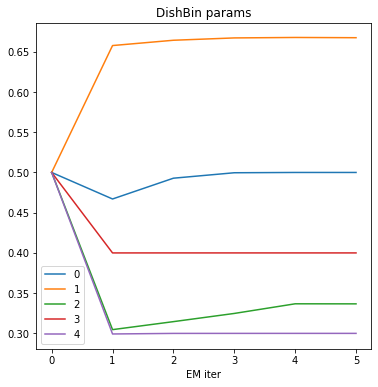

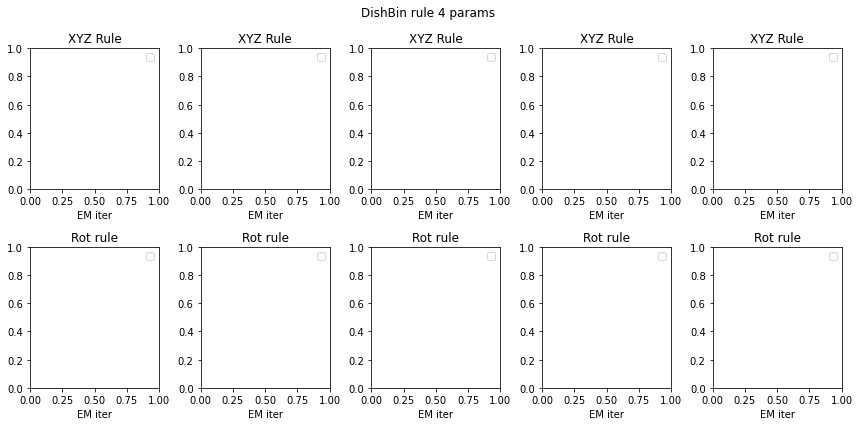

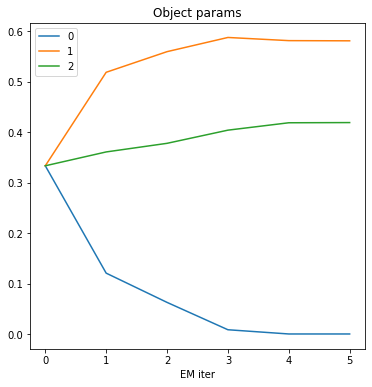

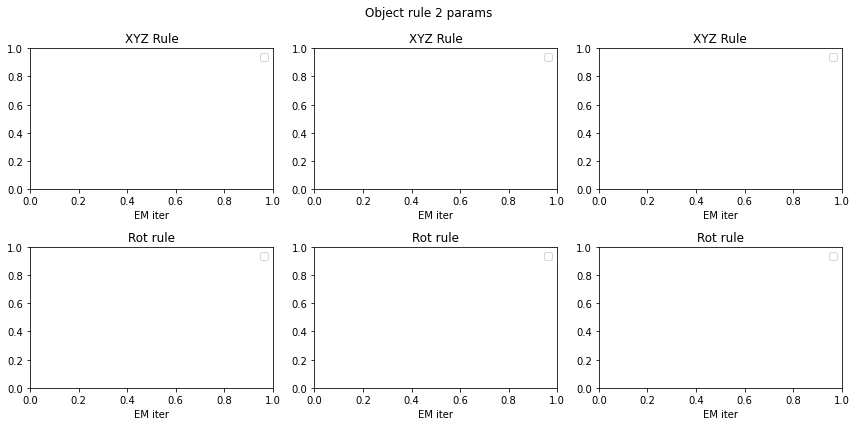

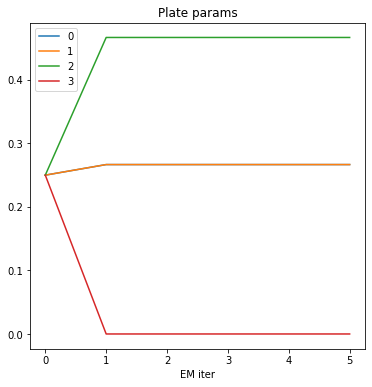

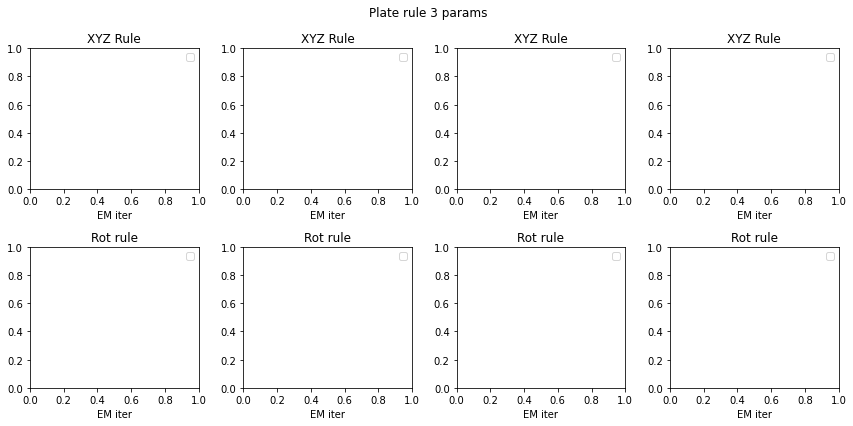

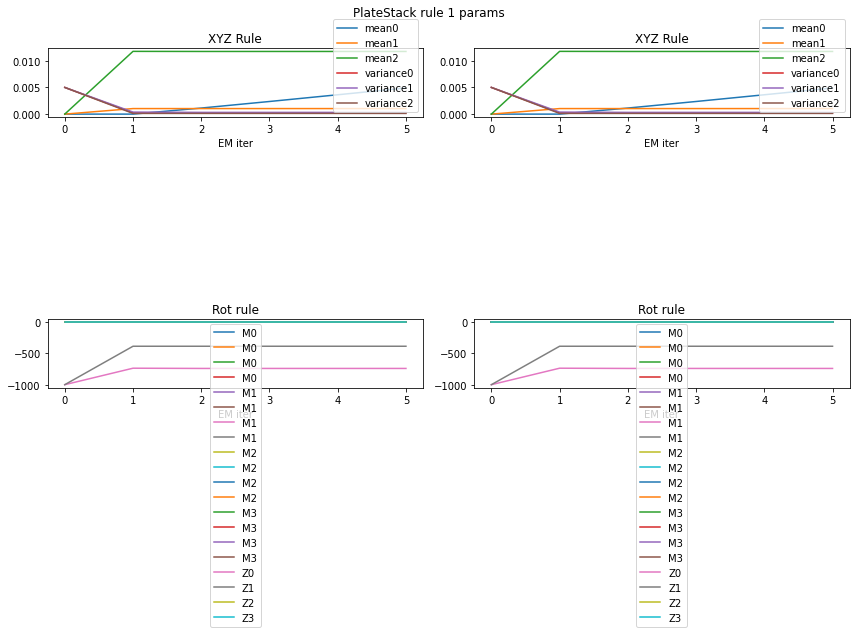

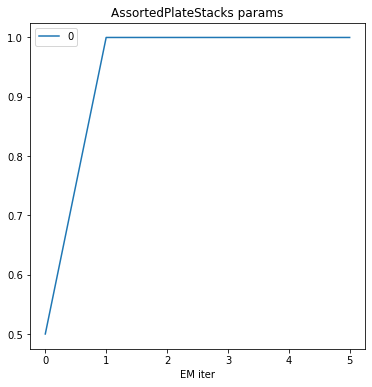

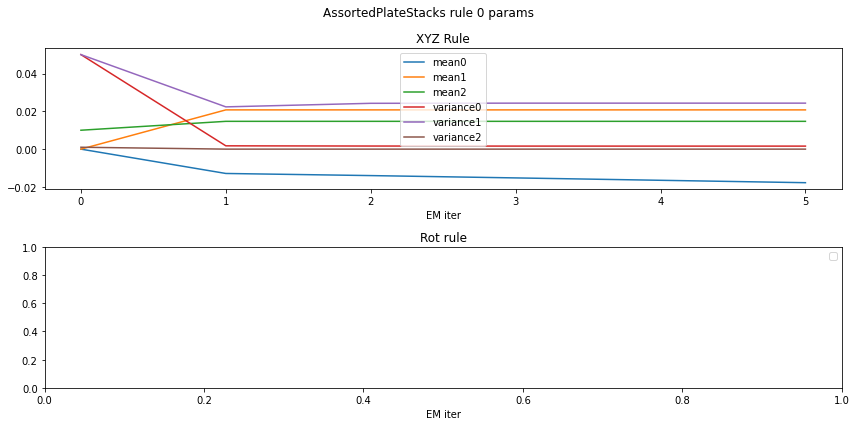

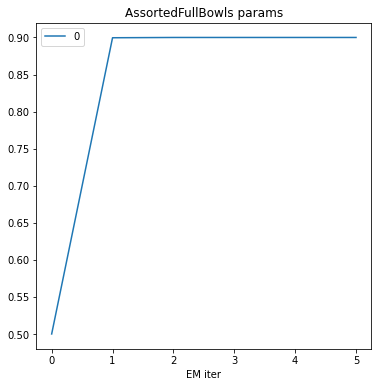

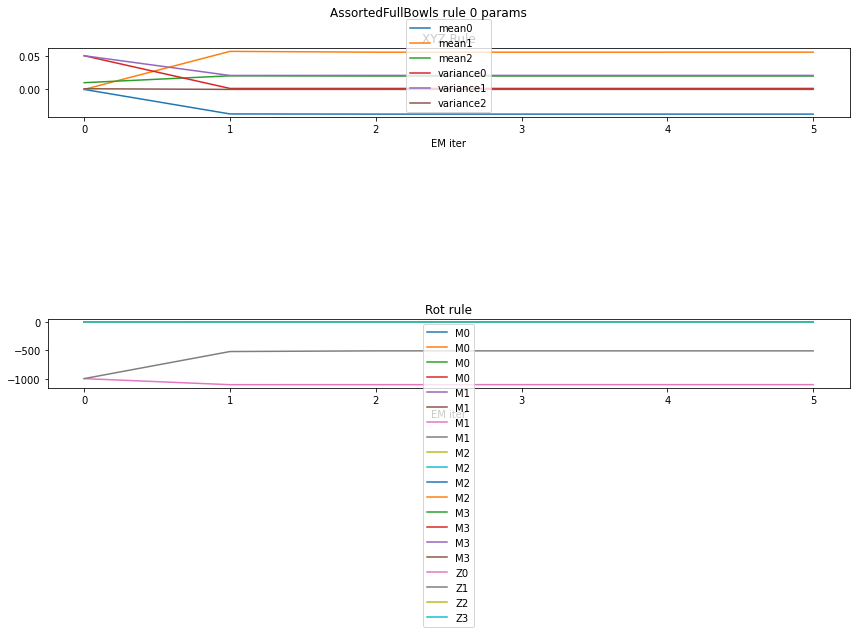

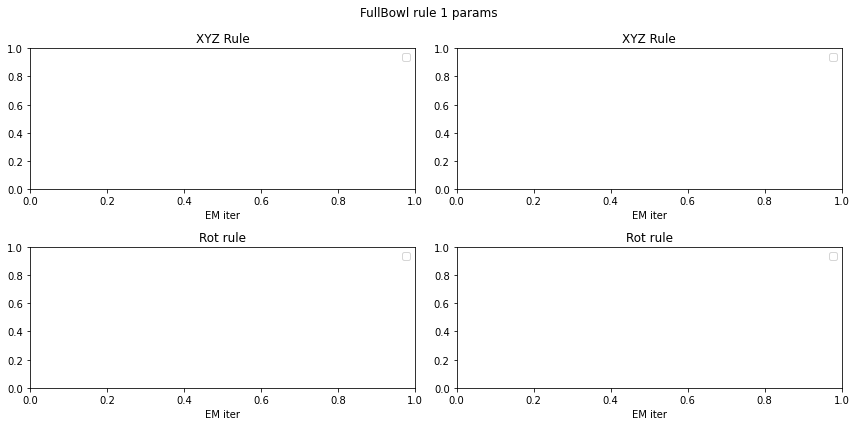

In [31]:
em.plot_grammar_parameter_history(DishBin)
em.plot_grammar_parameter_history(Object)
print("Plate")
em.plot_grammar_parameter_history(Plate)
print("PlateStack")
em.plot_grammar_parameter_history(PlateStack)
print("AssortedPlateStacks")
em.plot_grammar_parameter_history(AssortedPlateStacks)
print("AssortedFullBowls")
em.plot_grammar_parameter_history(AssortedFullBowls)
print("FullBowl")
em.plot_grammar_parameter_history(FullBowl)

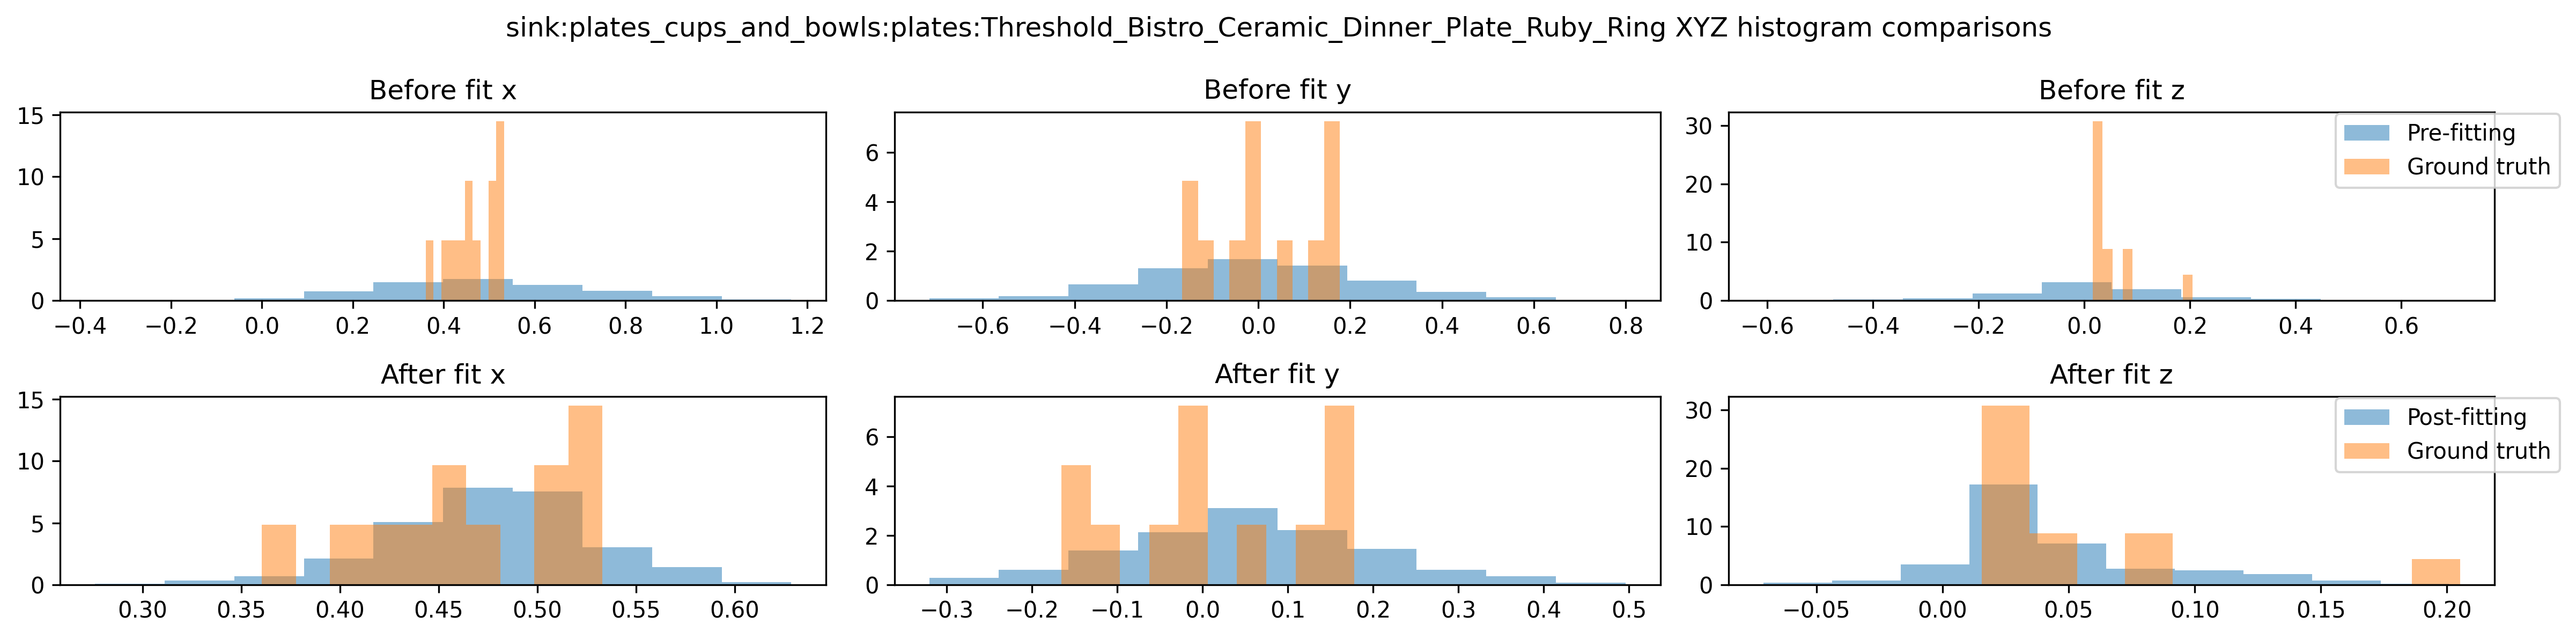

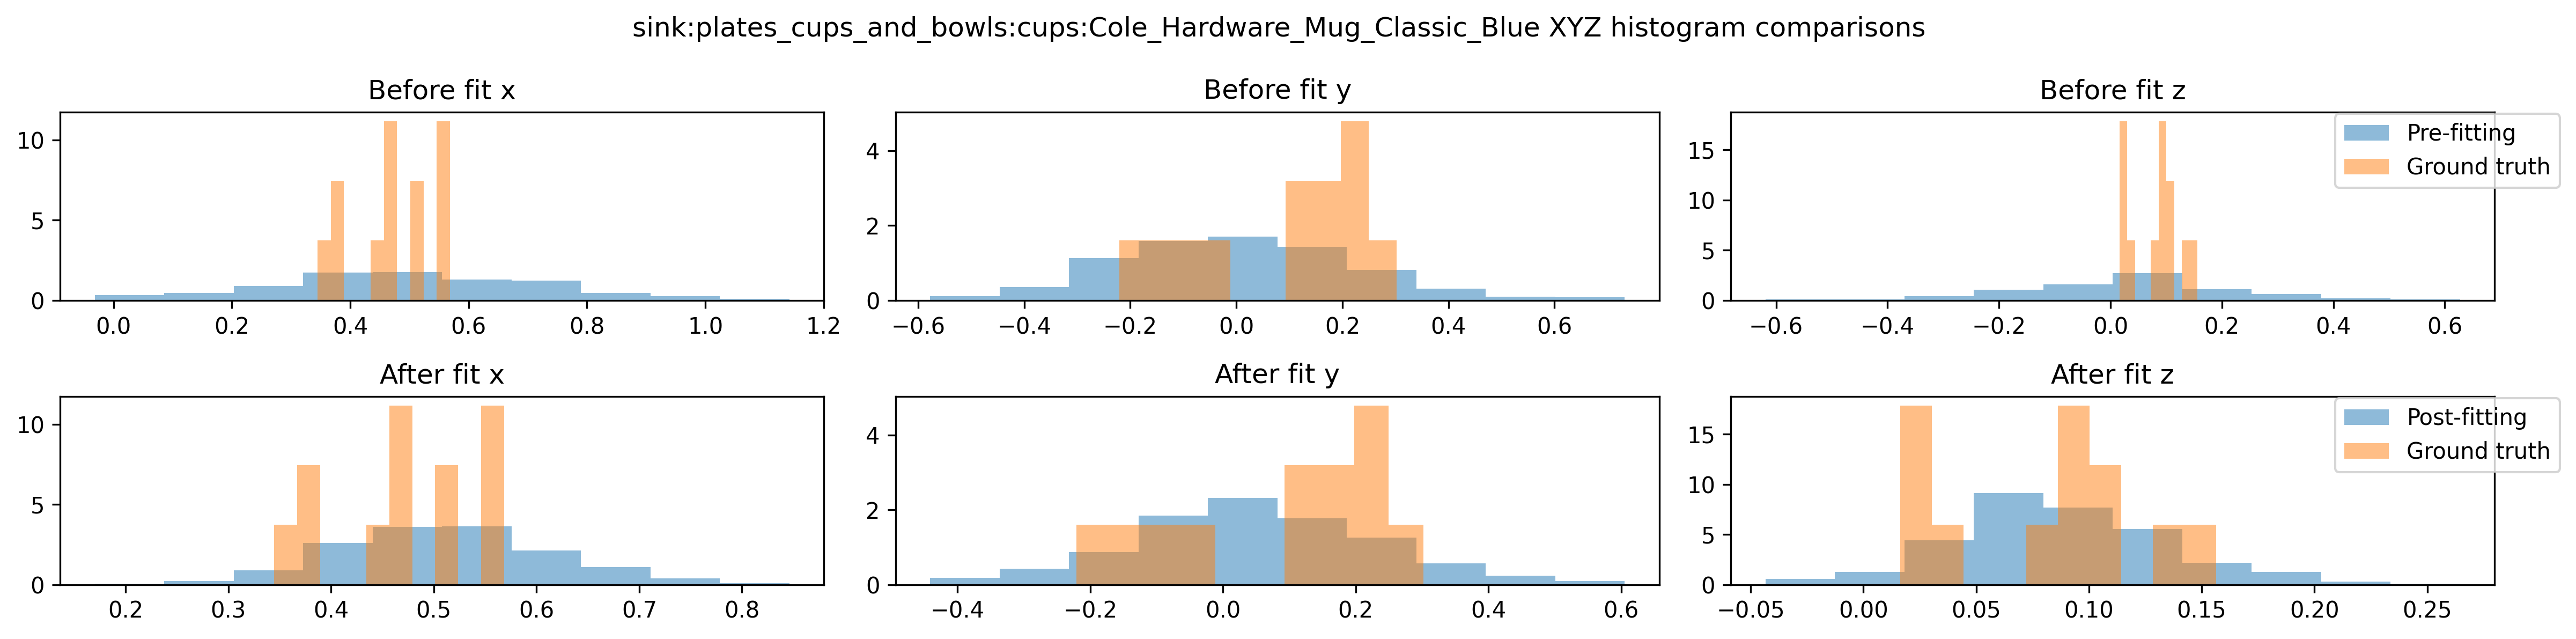

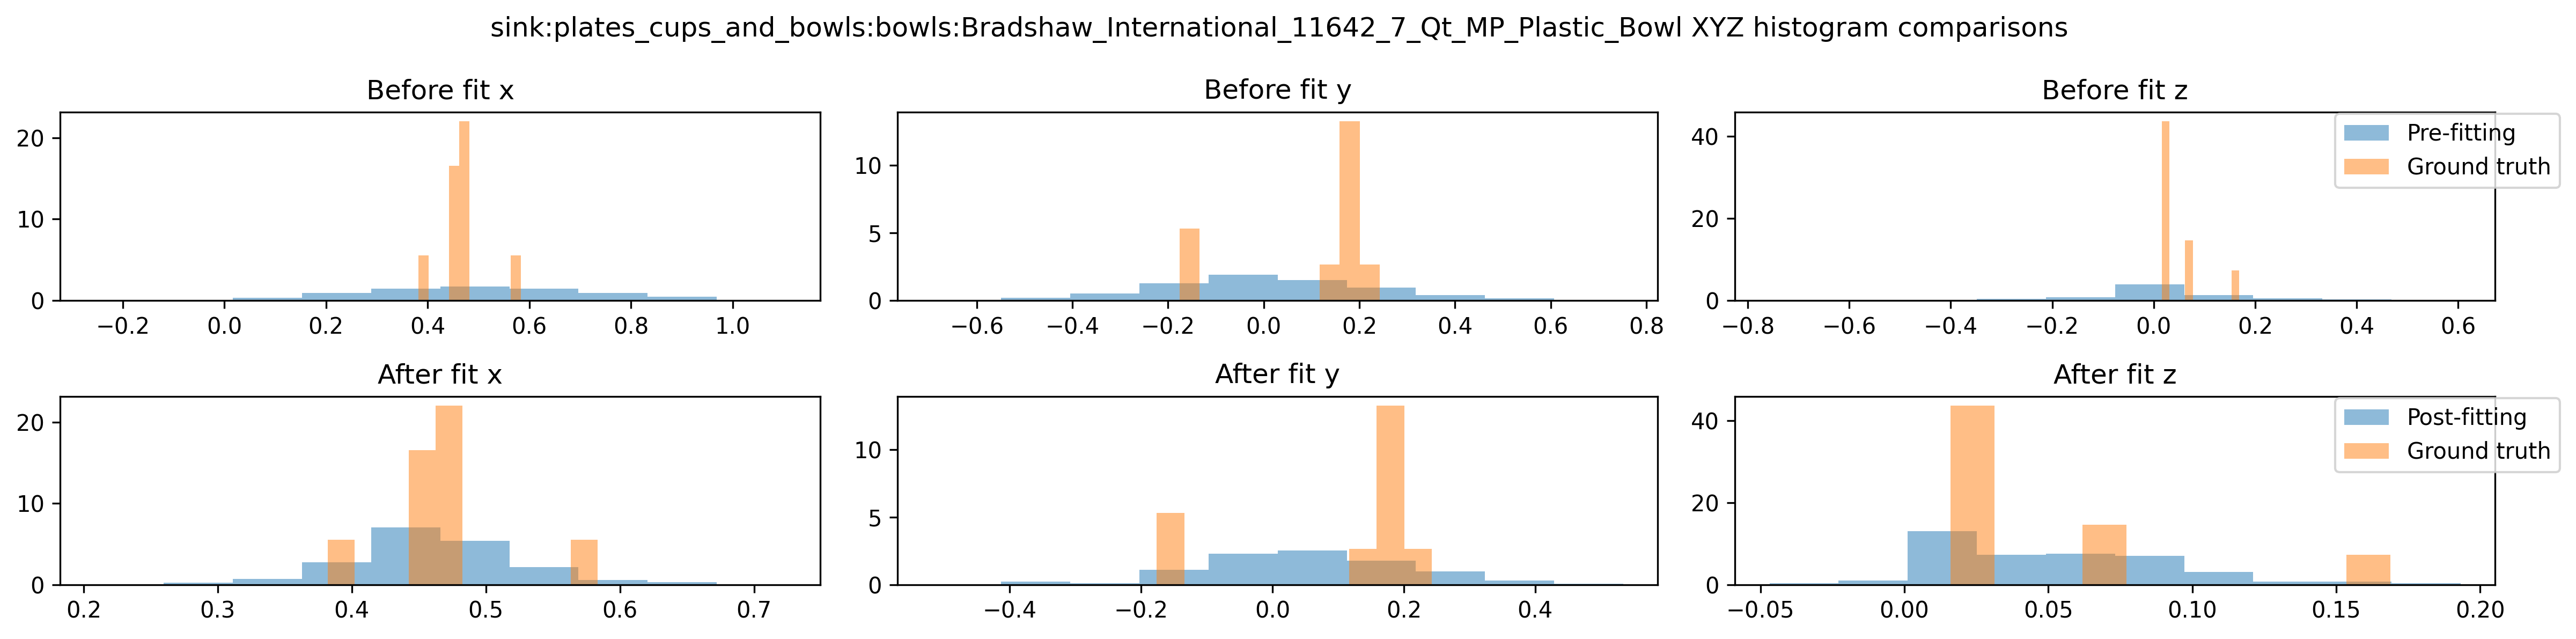

In [32]:
def get_all_node_xyzs(sampled_trees, node_type):
    l = []
    for tree in sampled_trees:
        for node in tree:
            if isinstance(node, node_type):
                l.append(node.translation.detach().cpu().numpy())
    return np.stack(l)
def plot_post_fit_tree_samples(em, N_samples=100):
    pre_fit_samples= []
    em.grammar.load_state_dict(em.grammar_iters[0])
    for k in range(N_samples):
        pre_fit_samples.append(em.grammar.sample_tree(detach=True))
    fit_samples = []
    em.grammar.load_state_dict(em.grammar_iters[-1])
    for k in range(N_samples):
        fit_samples.append(em.grammar.sample_tree(detach=True))

    for node_type in [PlateModels[0], CupModels[0], BowlModels[0]]:
        plt.figure(dpi=300).set_size_inches(16, 4)
        plt.suptitle("%s XYZ histogram comparisons" % node_type.__name__)

        gt_l = get_all_node_xyzs([SceneTree.make_from_observed_nodes(sample) for sample in observed_node_sets], node_type)
        fit_l = get_all_node_xyzs([sample for sample in fit_samples], node_type)
        pre_fit_l = get_all_node_xyzs([sample for sample in pre_fit_samples], node_type)
        # Pre fit
        for k in range(3):
            plt.subplot(2, 3, k+1)
            plt.title("Before fit %s" % "xyz"[k:(k+1)])
            plt.hist(pre_fit_l[:, k], label="Pre-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))

        for k in range(3):
            plt.subplot(2, 3, k+1+3)
            plt.title("After fit %s" % "xyz"[k:(k+1)])
            plt.hist(fit_l[:, k], label="Post-fitting", alpha=0.5, density=True)
            plt.hist(gt_l[:, k], label="Ground truth", alpha=0.5, density=True)
            if k == 2:
                plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
plot_post_fit_tree_samples(em, N_samples=1000)

In [35]:
# Draw some samples from the fit posterior
vis["fit_samples"].delete()
for k in range(5):
    tree = grammar.sample_tree(detach=True)
    draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/contents" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="fit_samples/%d/structure" % k)

# Test parsing a scene

In [ ]:
# Set up grammar
grammar = SpatialSceneGrammar(
    root_node_type = DishBin,
    root_node_tf = drake_tf_to_torch_tf(RigidTransform(p=[0.5, 0., 0.]))
)
grammar.load_state_dict(torch.load("fit_grammar.torch"))

In [ ]:
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.
results = infer_mle_tree_with_mip(grammar, observed_node_sets[8], N_solutions=1, max_recursion_depth=10, verbose=True)
trees = get_optimized_trees_from_mip_results(results)
vis["parses"].delete()
for k, tree in enumerate(trees[:1]):
    if k == 0:
        draw_scene_tree_contents_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/contents/%d" % k)
    draw_scene_tree_structure_meshcat(tree, zmq_url=vis.window.zmq_url, prefix="parses/structure/%d" % k, alpha=0.25, node_sphere_size=0.01)
    print("Computed score %f, optimization score %f" % (tree.score(verbose=0), results.optim_result.get_suboptimal_objective(k)))

In [ ]:
# Parse all scenes in dataset, and return by best score.
# Parse that dummy observation; it should have only one unique parse, since there's only one
# object.

with open("observed_outlier_node_sets.dat", "rb") as f:
    observed_node_sets_outliers = pickle.load(f)
    
parses = get_map_trees_for_observed_node_sets(grammar, observed_node_sets, N_solutions=1, num_workers=10, tqdm=tqdm)
parses = [parse[0] for parse in parses]
scores = torch.stack([parse.score() for parse in parses]).detach().numpy()

parses_outliers = get_map_trees_for_observed_node_sets(grammar, observed_node_sets_outliers, N_solutions=1, num_workers=10, tqdm=tqdm)
parses_outliers = [parse[0] for parse in parses_outliers]
scores_outliers = torch.stack([parse.score() for parse in parses_outliers]).detach().numpy()

In [ ]:
inds_ascending = np.argsort(scores, axis=0)
print("Ranking: ", inds_ascending)
plt.hist(scores, bins=100, label="Training set")
plt.hist(scores_outliers, bins=100, label="Outliers")
plt.xlabel("Log-prob of best parse tree")
plt.ylabel("Occurance in dataset")
plt.legend()
print(parses[-1].score(verbose=True))